In [ ]:
!pip install --user meld phate diffxpy magic-impute graphtools

In [4]:
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
import sklearn
import scipy
import seaborn as sns

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# making sure plots & clusters are reproducible
np.random.seed(42)

import diffxpy.api as de


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Using MELD to characterize TCR stimulation using thresholding
- characterize the effect of TCR stimulation with alpha-CD3/CD28 beads.

In [5]:
data_URL = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE92872&format=file&file=GSE92872%5FCROP%2Dseq%5FJurkat%5FTCR%2Edigital%5Fexpression%2Ecsv%2Egz"
data = pd.read_csv(data_URL, header=None, skiprows=6, index_col=0, compression="gzip").T
data.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,AAAS,AACS,AACSP1,AADAC,AADACL2-AS1,AADACL3,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,AB015752.3,AB019438.66,AB019440.50,AB019441.29,ABAT,ABBA01014710.1,ABBA01017803.1,ABBA01031658.1,ABBA01031664.1,ABC12-49244600F4.4,...,ZSCAN25,ZSCAN26,ZSCAN29,ZSCAN30,ZSCAN31,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZSWIM8,ZSWIM8-AS1,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,bP-21201H5.1,bP-21264C1.1,bP-21264C1.2,bP-2168N6.3,bP-2189O9.2,chr22-38_28785274-29006793.1,hsa-mir-1587,hsa-mir-3149,hsa-mir-4259,snosnR66,yR211F11.2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
metadata = pd.read_csv(data_URL, header=None, nrows=5, index_col=0, compression="gzip").T
metadata['is_stimulated'] = metadata['condition'] == 'stimulated'
metadata.head()

,condition,replicate,cell,grna,gene,is_stimulated
1,stimulated,1,TACTTGACCCCN,CTRL00320,CTRL,True
2,stimulated,1,TTACAGCTGAAC,Tcrlibrary_JUND_2,JUND,True
3,stimulated,1,CTAAGGCCCTTA,Tcrlibrary_BACH2_3,BACH2,True
4,stimulated,1,CTTGACGCAGGT,Tcrlibrary_NFKB2_3,NFKB2,True
5,stimulated,1,TAACCCGTACGC,Tcrlibrary_JUN_1,JUN,True


### Create index
The original data has only numbered indices, but this is easy to mix up using Pandas. To make sanity checks easier, we'll use a concatenation of the cell barcode, gene targeted in that cell, and the stimulation condition

In [8]:
data.index = ['.'.join([c, g, co]) for i, (c, g, co) in metadata[['cell', 'gene', 'condition']].iterrows()]
metadata.index = data.index

### Filtering library size
- removing high library cells as protection against doublets

In [9]:
data = scprep.filter.filter_library_size(data, cutoff=25000, keep_cells='below')

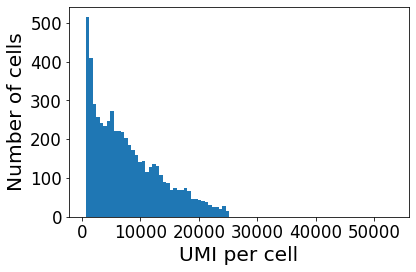

In [10]:
scprep.plot.plot_library_size(data, range=(0, 60000), log=False)
plt.xlabel('UMI per cell')
plt.ylabel('Number of cells')
plt.xlim(-2219.9500000000000003, 55972.95)
plt.tight_layout()

In [11]:
metadata['targeting_essential'] = np.array([g in ['DHODH', 'MVD', 'TUBB'] for g in metadata['gene'].values])

- removing genes from CRISPR library

Some cells expressed gRNA barcodes, but we don't want to use these to build a graph

In [12]:
artificial_genes = np.array(['library' in g for g in data.columns])

data = data.loc[:, ~artificial_genes]
data = scprep.filter.filter_rare_genes(data)

- remove low quality cells

Filtering genes based on mito RNA and other genes that were filtered in the published analysis


In [13]:
# filter mito expression & lib size
mito_genes = np.array([g.startswith('MT-') for g in data.columns])
data_zs = scipy.stats.zscore(scprep.normalize.library_size_normalize(data))
mito_expression = np.mean(data_zs[:, mito_genes], axis=1)
data = data.loc[(mito_expression < 1)]


In [14]:
# remove mito ribo genes, MRP, RP, RPT, RPU
mito_ribo_genes = np.array([((g.startswith('MT-')) | (g.startswith('MRP')) | (g.startswith('RP') & (~(g.startswith('RPT') | g.startswith('RPU'))))) for g in data.columns]).astype(bool)
data = data.loc[:, ~mito_ribo_genes]

# Measure library size
metadata = metadata.loc[data.index]
metadata['library_size'] = scprep.measure.library_size(data)

### Normalization and transformation

In [15]:
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)


### Run PHATE to visualize data

In [16]:
phateop = phate.PHATE()
data_phate = phateop.fit_transform(data)

Calculating PHATE...
  Running PHATE on 5591 observations and 18260 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 21.43 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.46 seconds.
    Calculating affinities...
    Calculated affinities in 0.61 seconds.
  Calculated graph and diffusion operator in 26.65 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.03 seconds.
    Calculating KMeans...
    Calculated KMeans in 35.07 seconds.
  Calculated landmark operator in 37.84 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 5.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.89 seconds.
Calculated PHATE in 80.75 seconds.


### Run MELD to calculate relative likelihood of stimulation

In [17]:
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(data, metadata['condition'])
sample_densities.index = data.index

Building graph on 5591 samples and 18260 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 22.08 seconds.
  Calculating KNN search...
  Calculated KNN search in 4.49 seconds.
  Calculating affinities...
  Calculated affinities in 0.61 seconds.
Calculated graph and diffusion operator in 27.75 seconds.


In [18]:
metadata['stimulated_likelihood'] = meld.utils.normalize_densities(sample_densities)['stimulated']

<AxesSubplot:>

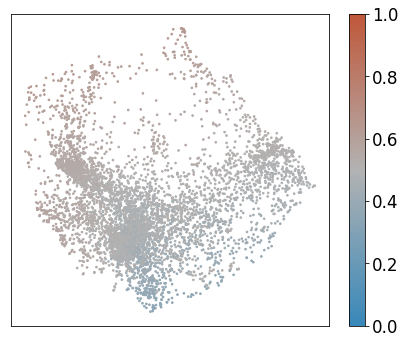

In [19]:
scprep.plot.scatter2d(data_phate, c=metadata['stimulated_likelihood'],
                      ticks=False, figsize=(6, 5),
                      vmin=0, vmax=1, cmap=meld.utils.get_meld_cmap())

This looks very grey because most of the values are between 0.3 and 0.6, indicating that the effect of bead stimulation is small wrt to the total biological variation

<AxesSubplot:ylabel='Number of cells'>

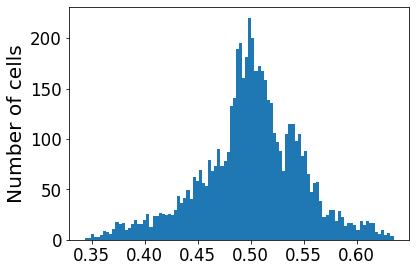

In [21]:
scprep.plot.histogram(metadata['stimulated_likelihood'])

<AxesSubplot:>

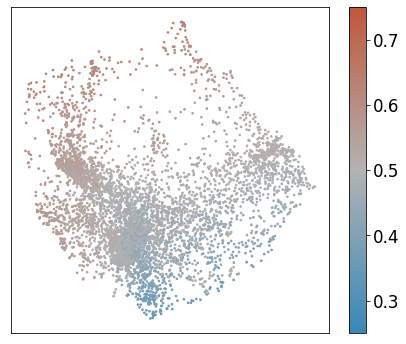

In [22]:
scprep.plot.scatter2d(data_phate, c=metadata['stimulated_likelihood'],
                      ticks=False, figsize=(6, 5),
                      vmin=0.25, vmax=.75, cmap=meld.utils.get_meld_cmap())

### Thresholding the relative likelihood using Mixture model

In [23]:
import sklearn.mixture
mixture_model = sklearn.mixture.GaussianMixture(n_components=3)
classes = mixture_model.fit_predict(metadata['stimulated_likelihood'].values.reshape(-1, 1))

In [24]:
# reorder the class labels so that 0 has the lowest average likelihood and 2 has the highest
classes = scprep.utils.sort_clusters_by_values(classes, metadata['stimulated_likelihood'])

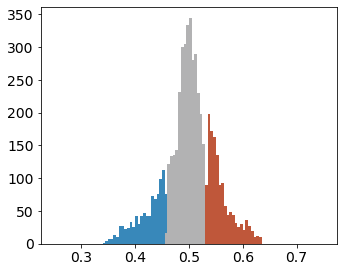

In [25]:
fig, ax = plt.subplots(1, figsize=(5, 4))
for c in np.unique(classes):
  ax.hist(metadata['stimulated_likelihood'][classes == c], range=(0.25, 0.75), bins=100,
          color=meld.utils.get_meld_cmap()([0, 255//2, 255])[c])
fig.tight_layout()

<AxesSubplot:>

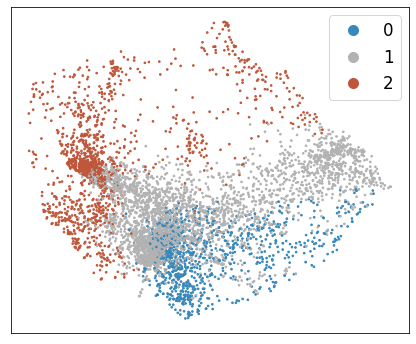

In [26]:
# Look at the clusters over the graph
scprep.plot.scatter2d(data_phate, c=classes,
                      ticks=False, figsize=(6, 5),
                      cmap=meld.utils.get_meld_cmap())

In [28]:
!pip install gseapy

     |████████████████████████████████| 525 kB 5.1 MB/s 
     |████████████████████████████████| 205 kB 58.3 MB/s 
     |████████████████████████████████| 44 kB 2.1 MB/s 
     |████████████████████████████████| 47 kB 3.5 MB/s 
     |████████████████████████████████| 255 kB 52.6 MB/s 
     |████████████████████████████████| 5.8 MB 35.9 MB/s 
     |████████████████████████████████| 251 kB 54.9 MB/s 
     |████████████████████████████████| 127 kB 56.2 MB/s 
  Created wheel for bioservices: filename=bioservices-1.7.12-py3-none-any.whl size=237514 sha256=d1198a49573be9aced0a57fa41c4defd512c2bde99e16aa4b4a5de03312a5614
  Stored in directory: /root/.cache/pip/wheels/88/9c/a0/5a7cf2456c5cc39ed47d2a3cdf8dd8316b5a81d20fde1ff63e
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=d33d73015fcfabe8b3b8758fc65c6281df883dc192e281c5be74328953bc26ca
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
  Created wh

In [29]:
import gseapy
import diffxpy.api as de

Creating directory /root/.config/bioservices 


### DE and GSEA
- now that we have the cells w/ the highest and lowest relative likelihood values, we can characterize them using DE

In [30]:
qval_thresh = 0.05

In [31]:
# depleted: class 0, enriched: class 2
de_results = de.test.two_sample(data[np.isin(classes, [0, 2])].values,
                                grouping=classes[np.isin(classes, [0, 2])],
                                gene_names=data.columns,
                                test='rank').summary()

In [33]:
significant_results = de_results.loc[de_results['qval'] < qval_thresh]
top_genes = significant_results['gene'].values

In [34]:
gene_sets = ['GO_Biological_Process_2018', 'NCI-Nature_2016']
terms = ['T cell activation (GO:0042110)',
         'TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303', 
         'C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303', 
         'TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303',
         'IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303',
         'IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303']

terms_pretty = {
    'T cell activation (GO:0042110)':'T cell\nactivation',
    'TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303':'TCR signaling\nin naive CD8+ T cells',
    'C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303':'C-MYB transcription\nfactor network',
    'TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303':'TCR signaling\nin naive CD4+ T cells',
    'IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303':'IL2 signaling events\nmediated by PI3K',
    'IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303':'IL6-mediated\nsignaling events'
}

In [40]:
enrich_dir = "EnrichR.Results/"
#gseapy.enrichr(list(top_genes), gene_sets, outdir=enrich_dir)



In [41]:
erichr = [pd.read_csv(enrich_dir + '{}.human.enrichr.reports.txt'.format(gene_sets[i]), delimiter='\t') for i in range(len(gene_sets))]
erichr = pd.concat(erichr, ignore_index=True)
erichr.set_index('Term').loc[terms]

,Gene_set,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
Term,,,,,,,,,
T cell activation (GO:0042110),GO_Biological_Process_2018,39/88,0.120822,0.510471,0,0,1.316910,2.783206,CHD7;PTPN22;CD3G;CD1C;CD3D;PIK3CG;HSPD1;PPP3CA...
TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303,NCI-Nature_2016,32/53,0.000666,0.005152,0,0,2.524596,18.467112,SHC1;CD3G;BCL10;RASGRP2;CD3D;RASGRP1;IKBKB;RAP...
C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303,NCI-Nature_2016,42/82,0.008533,0.040531,0,0,1.739264,8.285569,CDKN1A;CEBPB;LEF1;CLTA;YEATS4;IQGAP1;NLK;ETS1;...
TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303,NCI-Nature_2016,39/64,0.000135,0.001658,0,0,2.586135,23.045277,SHC1;PTEN;STK39;WAS;CD3G;BCL10;RASGRP2;CD3D;RA...
IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303,NCI-Nature_2016,18/35,0.068101,0.167448,0,0,1.751521,4.705930,HSP90AA1;SHC1;PTPN11;IL2RG;NFKB1;IL2;TERT;LCK;...
IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303,NCI-Nature_2016,20/46,0.253416,0.456586,0,0,1.271890,1.745952,MAP2K4;PIAS3;CEBPB;JUN;STAT1;LMO4;PTPN11;FOS;M...


In [ ]:
GO_Biological_Process_2018.human.enrichr.reports